In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# **Cargar Dataset**

In [2]:
sarcasm_data = pd.read_json('dataset/Sarcasm_Headlines_Dataset_v2.json',lines=True)
sarcasm_data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
# Remover la columna 'article_link' que no se necesita
sarcasm_data.drop('article_link', axis=1, inplace=True)
sarcasm_data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [4]:
len(sarcasm_data)

28619

In [5]:
# Separar los datos en frases y etiquetas para su procesamiento
headline_tmp = sarcasm_data['headline'].tolist()
labels = sarcasm_data['is_sarcastic'].tolist()

In [6]:
headline_tmp[0:10]

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep. totally nails why congress is falling short on gender, racial equality',
 'eat your veggies: 9 deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 "mother comes pretty close to using word 'streaming' correctly",
 'my white inheritance',
 '5 ways to file your taxes with less stress',
 "richard branson's global-warming donation nearly as much as cost of failed balloon trips",
 'shadow government getting too large to meet in marriott conference room b',
 'lots of parents know this scenario']

In [7]:
labels[0:10]

[1, 0, 0, 1, 1, 0, 0, 1, 1, 0]

In [8]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Eliminar las stopwords y los signos de puntuacion

# stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
stopwords = set(stopwords.words('english'))

# Eliminar las stopwords de las frases
headline = []
for sent in headline_tmp:
   filtered_list = []
   for word in sent.split():
     if word not in stopwords:
       filtered_list.append(word)
   join_str = ' '.join([str(ele) for ele in filtered_list])
   headline.append(join_str)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
headline[0:10]

['thirtysomething scientists unveil doomsday clock hair loss',
 'dem rep. totally nails congress falling short gender, racial equality',
 'eat veggies: 9 deliciously different recipes',
 'inclement weather prevents liar getting work',
 "mother comes pretty close using word 'streaming' correctly",
 'white inheritance',
 '5 ways file taxes less stress',
 "richard branson's global-warming donation nearly much cost failed balloon trips",
 'shadow government getting large meet marriott conference room b',
 'lots parents know scenario']

# **Distribucion de los datos**

## **Histograma**

In [10]:
sarcasm_data['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

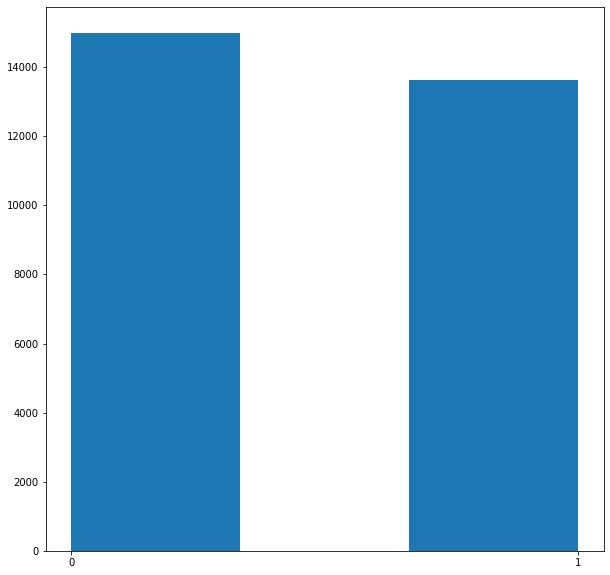

In [11]:
plt.figure(figsize=(10,10))
plt.hist(sarcasm_data['is_sarcastic'],bins=3)
plt.xticks([0,1])
plt.show()

# **Tamaño de las frases**

In [12]:
# Crear una nueva columna en el dataframe con la cantidad de palabras en cada frase
sarcasm_data['headline_length'] = sarcasm_data['headline'].apply(lambda x: len(x.split())) 

In [13]:
sarcasm_data['headline_length'].head()

0     8
1    13
2     7
3     8
4     9
Name: headline_length, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


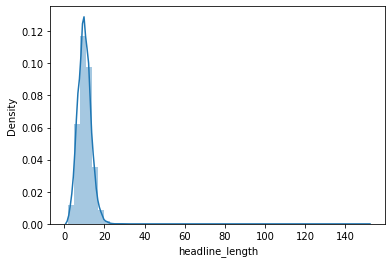

In [14]:
import seaborn as sns

sns.distplot(sarcasm_data['headline_length'])

In [15]:
sarcasm_data['headline_length'].describe()

count    28619.000000
mean        10.049967
std          3.388307
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
max        151.000000
Name: headline_length, dtype: float64

In [16]:
# Con este cuantil vemos que la mayoria de las frases tienen un tamaño menor a 32 palabras.
# Esto lo usaremos como el tamaño maximo para cada frase cuando procesamos los datos.

sarcasm_data['headline_length'].quantile(0.9999)

31.967399999983172

# **Preprocesamiento**

In [17]:
# Definir parametros

embedding_dim = 100
max_length = 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [18]:
# Dividir los datos en datos de entrenamiento y validacion utilizando el parametro training_size

train_sentences = headline[:training_size]
train_labels = labels[:training_size]

validation_sentences = headline[training_size:]
validation_labels = labels[training_size:]

print(training_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

20000
20000
20000
8619
8619


In [19]:
# tokenizer -> para tokenizar y transformar las palabras en datos numericos
# pad_sequences -> para rellenar los datos para que tengan la misma longitud (max_length)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(headline)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(train_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [20]:
# El tamaño del vocabulario sera el numero total de palabras en word_index identificadas por el tokenizer a partir de los datos de entrenamiento.
len(word_index)

30820

In [21]:
training_sequences[0]

[15936, 261, 3067, 7384, 2540, 554, 1019]

In [22]:
training_padded[0]

array([15936,   261,  3067,  7384,  2540,   554,  1019,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [23]:
# Convertir a arrays de numpy

training_padded = np.array(training_padded)
validation_padded = np.array(validation_padded)
training_labels_pad = np.array(train_labels)
validation_labels_pad = np.array(validation_labels)

# **Modelo usando GloVe para el Embedding**

In [24]:
from google.colab import drive
drive.mount('/content/drive')

vocab_size = len(word_index)

# para cada linea en el archivo glove, el primer valor es la palabra y el segundo valor es el embedding (array de 100 dimensiones)
# Almacenar los valores en un diccionario
embeddings_index = {}
with open('drive/MyDrive/sarcasmo/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word]=coefs

# inicializar una matriz de ceros y luego asignar la codificacion de las palabras en el vocabulario al indice apropiado en embedding_matrix
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for key in sorted(word_index, key=word_index.get)[:vocab_size]:
    embedding_vector = embeddings_index.get(key)
    if embedding_vector is not None:
        embeddings_matrix[word_index[key]] = embedding_vector

Mounted at /content/drive


In [25]:
embeddings_matrix.shape

(30821, 100)

In [26]:
# Primeras 10 palabras y el indice correspondiente del diccionario word_index que contiene el vocabulario

for key in sorted(word_index, key=word_index.get)[:10]:
  print(key,end=' ')
  print(word_index.get(key))

<OOV> 1
new 2
trump 3
man 4
report 5
one 6
year 7
day 8
u 9
area 10


In [27]:
# Embeddings para las primeras 10 palabras

for key in sorted(word_index, key=word_index.get)[:10]:
  print(key,end=' ')
  print(embeddings_index.get(key))

<OOV> None
new [-4.3959e-02  1.8936e-01  6.6110e-01 -4.9007e-01  3.2211e-01 -3.4161e-01
 -6.8480e-02  3.1364e-01 -7.1142e-01  5.7436e-01 -3.3588e-01 -5.2279e-01
 -3.9075e-01 -8.9694e-02  4.6371e-01 -3.5610e-01  8.4576e-01 -2.6188e-02
 -1.9328e-01 -8.3846e-02  3.1806e-01 -1.9812e-01  3.0009e-01  6.9189e-02
  5.4470e-01 -5.9193e-01  5.4221e-01 -6.2876e-01 -5.3447e-01  4.2334e-01
  3.0869e-02  9.7164e-01 -5.6222e-01  4.5752e-02 -5.7100e-01  8.0185e-02
 -8.1434e-02 -6.0260e-01  1.6466e-01 -4.0281e-01 -4.7701e-01 -5.1950e-01
  1.2777e-01 -4.3775e-01  2.6602e-01  4.8752e-01 -6.0220e-02 -5.2622e-01
  3.7687e-01 -1.8007e-01  3.0166e-02 -9.4577e-02  1.6330e-01  5.9041e-01
 -4.8877e-01 -3.4230e+00  1.3113e-01 -8.0386e-02  1.8978e+00  1.8857e-01
 -5.7300e-01  8.6358e-01  2.1116e-03  3.6060e-01  8.0475e-01 -1.3954e-01
 -5.3935e-02  3.8873e-01  3.0673e-01 -3.1395e-01  8.3238e-02 -4.1737e-01
 -1.0998e+00 -8.8005e-01  2.1550e-01 -2.6132e-01 -1.0091e-01  7.9584e-02
 -1.2341e+00 -6.5281e-01  6.3363e-01

In [28]:
embeddings_matrix[word_index['new']]

array([-4.39589992e-02,  1.89359993e-01,  6.61099970e-01, -4.90069985e-01,
        3.22109997e-01, -3.41610014e-01, -6.84799999e-02,  3.13639998e-01,
       -7.11420000e-01,  5.74360013e-01, -3.35880011e-01, -5.22790015e-01,
       -3.90749991e-01, -8.96940008e-02,  4.63710010e-01, -3.56099993e-01,
        8.45759988e-01, -2.61879992e-02, -1.93279997e-01, -8.38460028e-02,
        3.18060011e-01, -1.98119998e-01,  3.00089985e-01,  6.91889971e-02,
        5.44700027e-01, -5.91929972e-01,  5.42209983e-01, -6.28759980e-01,
       -5.34470022e-01,  4.23339993e-01,  3.08689997e-02,  9.71639991e-01,
       -5.62219977e-01,  4.57520001e-02, -5.70999980e-01,  8.01850036e-02,
       -8.14339966e-02, -6.02599978e-01,  1.64660007e-01, -4.02810007e-01,
       -4.77010012e-01, -5.19500017e-01,  1.27770007e-01, -4.37750012e-01,
        2.66020000e-01,  4.87520009e-01, -6.02199994e-02, -5.26220024e-01,
        3.76870006e-01, -1.80069998e-01,  3.01660001e-02, -9.45769995e-02,
        1.63299993e-01,  

In [29]:
# El modelo usa como pesos la matriz de embeddings anterior

vocab_size = len(word_index)

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [30]:
history = model.fit(training_padded, training_labels_pad, batch_size = 128, epochs = 30, validation_data=(validation_padded,validation_labels_pad), callbacks = [callback])

Epoch 1/30
157/157 [==============================] - 19s 59ms/step - loss: 0.5527 - accuracy: 0.7119 - val_loss: 0.4444 - val_accuracy: 0.7989
Epoch 2/30
157/157 [==============================] - 8s 48ms/step - loss: 0.3972 - accuracy: 0.8189 - val_loss: 0.3802 - val_accuracy: 0.8275
Epoch 3/30
157/157 [==============================] - 8s 48ms/step - loss: 0.2981 - accuracy: 0.8730 - val_loss: 0.3763 - val_accuracy: 0.8292
Epoch 4/30
157/157 [==============================] - 8s 49ms/step - loss: 0.2247 - accuracy: 0.9082 - val_loss: 0.3900 - val_accuracy: 0.8362
Epoch 5/30
157/157 [==============================] - 8s 48ms/step - loss: 0.1677 - accuracy: 0.9342 - val_loss: 0.3883 - val_accuracy: 0.8383
Epoch 6/30
157/157 [==============================] - 8s 48ms/step - loss: 0.1293 - accuracy: 0.9495 - val_loss: 0.4771 - val_accuracy: 0.8264
Epoch 7/30
157/157 [==============================] - 8s 50ms/step - loss: 0.0978 - accuracy: 0.9640 - val_loss: 0.5160 - val_accuracy: 0.832

In [31]:
# Guardar el modelo
model.save("modelo/sarcasm_GloVe_model.h5")

In [32]:
# Cargar el modelo y evaluar los datos de validacion
from tensorflow.keras.models import load_model

model = load_model('modelo/sarcasm_GloVe_model.h5')

In [33]:
model.evaluate(validation_padded,validation_labels_pad)

270/270 [==============================] - 6s 14ms/step - loss: 0.3883 - accuracy: 0.8383


[0.3883388340473175, 0.8382642865180969]

In [34]:
# Prediccion utilizando el mismo conjunto de datos de validacion para trazar la matriz de confusion

pred = (model.predict(validation_padded) > 0.5).astype("int32")

In [35]:
pred.shape

(8619, 1)

In [36]:
# Matriz de Confusion
from sklearn import metrics

cm=metrics.confusion_matrix(validation_labels_pad,pred)
print(cm)

[[4066  458]
 [ 936 3159]]


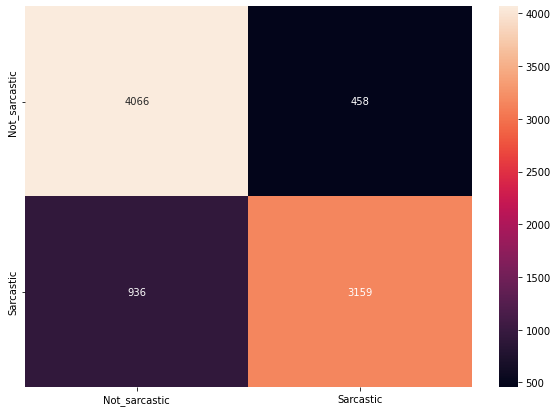

In [37]:
df_cm = pd.DataFrame(cm, index = [i for i in ['Not_sarcastic','Sarcastic']],
                                  columns = [i for i in ['Not_sarcastic','Sarcastic']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt = '1g')

In [38]:
# Frases para probar el modelo https://bestlifeonline.com/funniest-newspaper-headlines-of-all-time/

new_list = ['Miracle cure kills fifth patient','Cows lose their jobs as milk prices drop', 'Amphibious pitcher makes debut',
            'State population to double by 2040, babies to blame']

In [39]:
new_list[0]

'Miracle cure kills fifth patient'

In [41]:
# Preprocesamiento

# Eliminar las stopwords de las frases

new_headline = []
for sent in new_list:
    filtered_list = []
    for word in sent.split():
        if word not in stopwords:
            filtered_list.append(word)
    join_str = ' '.join([str(ele) for ele in filtered_list])
    new_headline.append(join_str)

In [42]:
new_headline

['Miracle cure kills fifth patient',
 'Cows lose jobs milk prices drop',
 'Amphibious pitcher makes debut',
 'State population double 2040, babies blame']

In [43]:
# Convertir la frase en datos numericos (tokenizar)

pred_sequences = tokenizer.texts_to_sequences(new_headline)
pred_padded = pad_sequences(pred_sequences, maxlen = max_length, padding = padding_type, truncating=trunc_type)

In [44]:
pred_padded

array([[ 2425,  3893,   704,  1227,  1935,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [ 9138,   706,   927,  2394,  3573,  1356,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [    1, 28699,    92,  3689,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [   58,  1833,  1442, 15745,  2458,  1667,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,  

In [45]:
# Prediccion
new_pred = (model.predict(pred_padded) > 0.5).astype("int32")

In [46]:
new_pred

# if new_pred[0]==1:
#     print('Sarcastic')
# else:
#     print('NOT sarcastic')

array([[1],
       [0],
       [0],
       [0]], dtype=int32)